In [1]:
import torch
import time
import os
import pickle
from helper.dataloader import *
from helper.model import *
from helper.utils import *
from helper.losses import *
import torch.nn as nn
import torch.nn.functional as F
from helper.distance_map import get_dist_map
import matplotlib.pyplot as plt
%matplotlib inline
dtype = torch.float32
device = torch.device("cuda")

#### Split test data by number of EC occurance in train

In [3]:
args_train_data = "uniref100_train_split_0"
args_test_data = "uniref100_test_split_0_curate"
id_ec_tr, ec_id_dict_tr = get_ec_id_dict('./data/uniref100/' + args_train_data + '.csv')
id_ec_te, ec_id_dict_te = get_ec_id_dict('./data/uniref100/' + args_test_data + '.csv')


In [4]:
csv_name = './data/' + args_test_data + '.csv'
csv_file = open(csv_name)
csvreader = csv.reader(csv_file, delimiter='\t')
 
n_bins = 5
out_writer_lst = []
for bin in range(n_bins):
    subset_file = './data/subset/' + \
        args_test_data + '_subset' + str(bin) + '.csv'
    out_file = open(subset_file, 'w', newline='')
    csvwriter = csv.writer(out_file, delimiter='\t')
    out_writer_lst.append(csvwriter)


for i, row in enumerate(csvreader):
    if i == 0:
        for bin in range(n_bins):
            out_writer_lst[bin].writerow(row)
    else:
        true_ec_lst = row[1].split(';')
        id_count_lst = [len(ec_id_dict_tr[ec]) for ec in true_ec_lst]
        id_count_ec = np.max(id_count_lst)

        if id_count_ec >= 2 and id_count_ec < 5:
            out_writer_lst[0].writerow(row)
        elif id_count_ec >= 5 and id_count_ec < 20:
            out_writer_lst[1].writerow(row)
        elif id_count_ec >= 20 and id_count_ec < 50:
            out_writer_lst[2].writerow(row)
        elif id_count_ec >= 50 and id_count_ec < 100:
            out_writer_lst[3].writerow(row)
        else:
            out_writer_lst[4].writerow(row)


### EC frequency uniref10

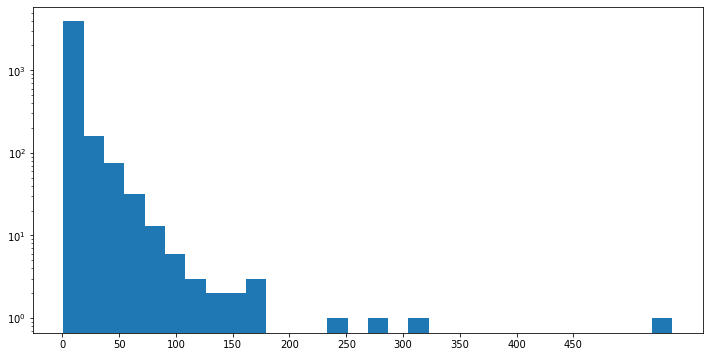

In [15]:
args_train_data = "uniref10_train_split_0"
args_test_data = "uniref10_test_split_0_curate"
id_ec_tr, ec_id_dict_tr = get_ec_id_dict('./data/uniref10/' + args_train_data + '.csv')
id_ec_te, ec_id_dict_te = get_ec_id_dict('./data/uniref10/' + args_test_data + '.csv')
EC_freq = []
for key in ec_id_dict_tr.keys():
    per_EC_id_count = len(ec_id_dict_tr[key])
    EC_freq.append(per_EC_id_count)
fig = plt.figure(figsize=(12, 6))
_ = plt.hist(EC_freq, bins=30)
_ = plt.yscale('log')
_ = plt.xticks(np.arange(0, 500, 50)) 


### EC frequency uniref100

In [4]:
args_train_data = "uniref100_train_split_0"
args_test_data = "uniref100_test_split_0_curate"
id_ec_tr, ec_id_dict_tr = get_ec_id_dict('./data/uniref100/' + args_train_data + '.csv')
id_ec_te, ec_id_dict_te = get_ec_id_dict('./data/uniref100/' + args_test_data + '.csv')


In [5]:
EC_freq = []
for key in ec_id_dict_tr.keys():
    per_EC_id_count = len(ec_id_dict_tr[key])
    EC_freq.append(per_EC_id_count)

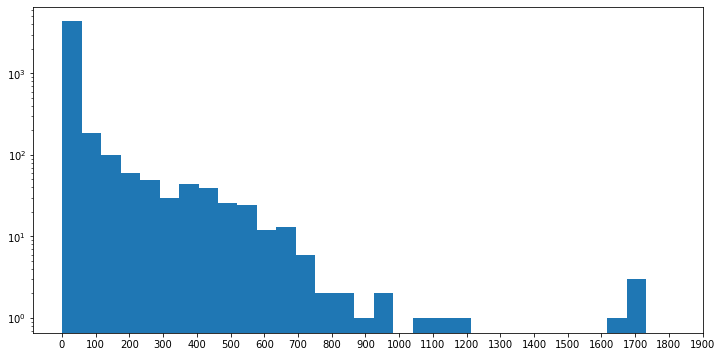

In [13]:
fig = plt.figure(figsize=(12, 6))
_ = plt.hist(EC_freq, bins=30)
_ = plt.yscale('log')
_ = plt.xticks(np.arange(0, 2000, 100)) 

### multiple postive multiple negative dataset/dataloader

In [3]:
n_pos = 9; n_neg = 20
def get_dataloader(dist_map, id_ec, ec_id, args):
    params = {
        'batch_size': 5000,
        'shuffle': True,
    }
    negative = mine_hard_negative(dist_map, 50)
    train_data = MultiPosNeg_dataset_with_mine_EC(
        id_ec, ec_id, negative, n_pos, n_neg)
    train_loader = torch.utils.data.DataLoader(train_data, **params)
    return train_loader


In [ ]:
args_train_data = "uniref10_train_split_1"
args_hidden_dim = 512
args_out_dim = 128
id_ec, ec_id_dict = get_ec_id_dict('./data/' + args_train_data + '.csv')
ec_id = {key: list(ec_id_dict[key]) for key in ec_id_dict.keys()}
model = LayerNormNet(args_hidden_dim, args_out_dim, device, dtype)
checkpoint = torch.load('./model/uniref10_split1_final.pth')
dist_map = pickle.load(
    open('./data/distance_map/uniref10_train_split_1.pkl', 'rb'))
args = []
train_loader = get_dataloader(dist_map, id_ec, ec_id, args)


In [9]:
for batch, data in enumerate(train_loader):
    print("number of pos:", n_pos, "; number of neg:", n_neg)
    print("size of one batch:", data.size())
    break

number of pos: 9 ; number of neg: 20
size of one batch: torch.Size([4223, 30, 1280])


### N-pair loss

In [2]:
seed_everything()
args_hidden_dim = 512
args_out_dim = 128
model = LayerNormNet(args_hidden_dim, args_out_dim, device, dtype)
checkpoint = torch.load('./model/uniref10_split1_final.pth')
model.zero_grad()
# the input to the model will be of size [bsz, (1+n_pos+n_neg), 1280]
n_pos = 1; n_neg = 30; bsz = 400; temp = 0.1
n_all = 1 + n_pos + n_neg
dummy_input = torch.randn(bsz, n_all, 1280).to(device, dtype)
model_emb = model(dummy_input)
loss = NPairLoss(model_emb, temp)
loss.backward()
print("loss is:", loss.item())
print("the grad of fc1 layer is:", model.fc1.weight.grad)

loss is: 6.433290481567383
the grad of fc1 layer is: tensor([[-4.8914e-03, -2.0231e-03,  4.1318e-03,  ..., -1.6695e-03,
          1.7229e-03, -2.7476e-03],
        [ 1.0904e-02, -1.3277e-02, -3.2206e-03,  ..., -1.7161e-03,
         -2.7405e-03, -7.5002e-03],
        [-3.0050e-03, -6.1143e-03, -3.8868e-03,  ...,  1.4125e-03,
          7.5213e-03,  6.8182e-03],
        ...,
        [ 4.4915e-03,  7.5347e-03, -3.2780e-03,  ...,  4.0461e-05,
          3.3811e-03, -7.3777e-03],
        [ 4.0005e-03, -3.6585e-03, -3.7010e-03,  ..., -8.1621e-03,
         -5.8130e-04, -1.2024e-03],
        [-3.7205e-03, -1.0952e-03, -5.4550e-03,  ..., -4.0717e-04,
          3.1118e-04,  9.3065e-03]], device='cuda:0')


### SupCon Loss

In [3]:
seed_everything()
args_hidden_dim = 512
args_out_dim = 128
model = LayerNormNet(args_hidden_dim, args_out_dim, device, dtype)
checkpoint = torch.load('./model/uniref10_split1_final.pth')
model.zero_grad()
# the input to the model will be of size [bsz, (1+n_pos+n_neg), 1280]
n_pos = 10; n_neg = 30; bsz = 400; temp = 0.1
n_all = 1 + n_pos + n_neg
dummy_input = torch.randn(bsz, n_all, 1280).to(device, dtype)
model_emb = model(dummy_input)
loss = SupConHardLoss(model_emb, temp, n_pos)
loss.backward()
print("loss is:", loss.item())
print("the grad of fc1 layer is:", model.fc1.weight.grad)

loss is: 6.3981146812438965
the grad of fc1 layer is: tensor([[-0.0002,  0.0006, -0.0036,  ..., -0.0042,  0.0003,  0.0011],
        [ 0.0089, -0.0080,  0.0055,  ..., -0.0009,  0.0020,  0.0026],
        [ 0.0008, -0.0011,  0.0004,  ...,  0.0025,  0.0010,  0.0015],
        ...,
        [ 0.0014, -0.0014,  0.0008,  ..., -0.0012, -0.0020, -0.0017],
        [-0.0009,  0.0002, -0.0023,  ..., -0.0014,  0.0006, -0.0015],
        [-0.0046,  0.0005,  0.0002,  ..., -0.0016, -0.0012, -0.0003]],
       device='cuda:0')
